# Накопления

В банковском приложении нельзя видеть активы из других мест, например, золото, валюту и другие финансовые инструменты. Поэтому стоит создать платформу, где можно учитывать все виды активов и получать актуальную информацию по ценным бумагам, облигациям и курсам валют с MOEX и exchangerate.com.

In [1]:
metals = Dict(
    "Георгий Победоносец 7.78г 2021" => 56_700,     # Сбер
    "Георгий Победоносец 7.78г 2024 ММД" => 56_700, # Россельхоз
)

loans = Dict(
    "долг 0% до 01.01.2025" => 300_000,                           # средний риск
    "долг 30% до 27.02.2024" => 200_000 + 200_000 * 6 / 12 * 0.3, # высокий риск
)

deposits = Dict(
    "бессрочный" => 1_100_000 + 1_100_000 * 1 / 12 * 0.17,
)

currency = Dict(
    # валюта
    "USD" => 3_800,
)

fonds = Dict(
    # фонды
    "SBMX" => 13_586, # IMOEX
    "SBSC" => 1_457, # 
    "SBPS" => 850, # прогрессивный смарт
    "SBGD" => 443, # золото
    "SBBY" => 5_608, # юани
    "SBGB" => 1_000, # облигации
)

flb = Dict(
    # ОФЗ
    "SU26218RMFS6" => 45,
    "SU26212RMFS9" => 25,
    "SU26207RMFS9" => 20,
    "SU26230RMFS1" => 20,
    "SU26232RMFS7" => 10,
    "SU26225RMFS1" => 28,
)

bonds = Dict(
    # корпоративные облигации
    "RU000A0ZYWY5" => 10,
)

stocks = Dict(
    # акции
    "SBER" => 260,
    "SBERP" => 260,
    "PLZL" => 3,
    "GAZP" => 280,
    "VKCO" => 46,
    "LKOH" => 2,
    "TCSG" => 5,
    "AFLT" => 250,
    "MBNK" => 7,
    "MTSS" => 60,
    "YDEX" => 3,
    "DIAS" => 2,
    "NVTK" => 9,
    "NLMK" => 60,
    "DELI" => 33,
    "TATN" => 13,
    "SPBE" => 58,
    "LSRG" => 10,
    "MOEX" => 30,
    "POSI" => 2,
    "LEAS" => 5,
    "RASP" => 10,
    "IVAT" => 10,
    "MTLR" => 20,
    "ROSN" => 3,
    "APTK" => 130,
    "KMAZ" => 10,
    # депозитарные расписки
    "OZON" => 3,
)

println("Все активы и пассивы созданы")

Все активы и пассивы созданы


### Получение данных с биржи MOEX

In [2]:
using HTTP

function fetch_security_data(url, key)
    response = HTTP.get(url)
    xml_data = String(response.body)
    return xml_data
end

sources = [
    ("SHARES/boards/TQBR", "акции"),
    ("SHARES/boards/TQTF", "ETF"),
    ("BONDS/boards/TQOB", "ОФЗ"),
    ("BONDS/boards/TQCB", "корпоративных облигации")
]

xml_data = Dict(key => fetch_security_data(
        "https://iss.moex.com/iss/engines/stock/markets/$(url)/securities.xml?iss.meta=off&iss.only=securities&securities.columns=SECID,PREVPRICE", 
        key
) for (url, key) in sources)

Dict{String, String} with 4 entries:
  "акции"                   => "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<do…
  "ETF"                     => "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<do…
  "корпоративных облигации" => "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<do…
  "ОФЗ"                     => "<?xml version=\"1.0\" encoding=\"UTF-8\"?>\n<do…

In [3]:
using LightXML

function get_prevprice(xml_string::String, secid::String)
    doc = parse_string(xml_string)
    xroot = find_element(root(doc), "data")
    
    for row in child_elements(find_element(xroot, "rows"))
        if is_elementnode(row)
            row_secid = attribute(row, "SECID")
            if row_secid == secid
                return parse(Float64, attribute(row, "PREVPRICE"))
            end
        end
    end

    println(secid, " не найден")
    return 0
end

get_prevprice (generic function with 1 method)

### Получение курса USD/RUB с ExchangeRate

In [4]:
using JSON

function get_current_usd_to_rub()
    response = HTTP.get("https://api.exchangerate-api.com/v4/latest/USD")
    data = JSON.parse(String(response.body))
    return data["rates"]["RUB"]
end

function convert_usd_to_rub(amount_usd)
    exchange_rate = get_current_usd_to_rub()
    amount_rub = amount_usd * exchange_rate
    return amount_rub
end

convert_usd_to_rub (generic function with 1 method)

### Статистика

In [5]:
using Plots

# Предполагаем, что есть функции get_prevprice, convert_usd_to_rub и словари stocks, fonds, flb, bonds, deposits, currency
metals_value = sum(value for (key, value) in pairs(metals))
loans_value = sum(value for (key, value) in pairs(loans))
stocks_value = sum(get_prevprice(xml_data["акции"], key) * value for (key, value) in pairs(stocks))
fonds_value = sum(get_prevprice(xml_data["ETF"], key) * value for (key, value) in pairs(fonds))
flb_value = sum(get_prevprice(xml_data["ОФЗ"], key) * value * 1000 / 100 for (key, value) in pairs(flb))
bonds_value = sum(get_prevprice(xml_data["корпоративных облигации"], key) * value for (key, value) in pairs(bonds))
deposits_value = sum(value for (key, value) in pairs(deposits))
currency_value = convert_usd_to_rub(get(currency, "USD", 0.0))
summary = stocks_value + fonds_value + flb_value + bonds_value + deposits_value + currency_value + metals_value + loans_value

# Данные для графика
assets = ["Акции", "ETF", "ОФЗ", "Облигации", "Вклады", "Валюта", "Металлы", "Займы"]
values = [stocks_value, fonds_value, flb_value, bonds_value, deposits_value, currency_value, metals_value, loans_value]

# Подсчет процентов для каждого типа актива
percents = [value / summary * 100 for value in values]

8-element Vector{Float64}:
 13.118129624412312
 10.68045106264101
  3.556954105010183
  0.03290556149054627
 38.52334554814626
 11.870312678405183
  3.9159310242711167
 18.301970395623382

In [6]:
println("Итоговая сумма: $(floor(Int, summary)) рублей")

Итоговая сумма: 2895863 рублей


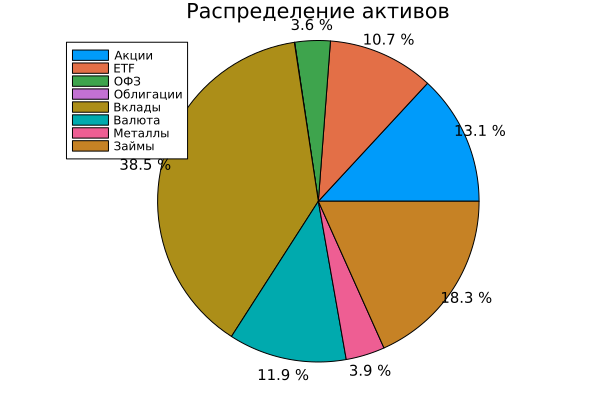

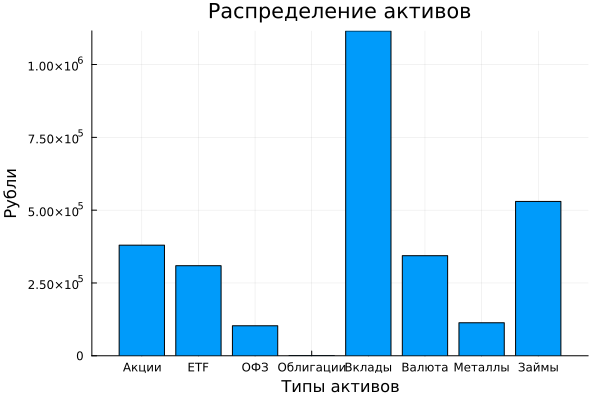

In [7]:
# Создание круговой диаграммы
pie_plot = pie(assets, percents, legend=true, title="Распределение активов")

# Добавление аннотаций с процентами
for i in 1:length(percents)
    if percents[i] < 0.1
        continue
    end
    
    angle = 2 * π * (sum(percents[1:i]) - percents[i] / 2) / 100
    radius = 1.1  # Радиус для аннотаций, немного больше радиуса круговой диаграммы
    x = radius * cos(angle)
    y = radius * sin(angle)
    annotate!(x, y, text(string(round(percents[i], digits=1), " %"), :center, 10))
end

# Создание бар-графика
bar_plot = bar(assets, values, title="Распределение активов", xlabel="Типы активов", ylabel="Рубли", legend=false)

# Отображение графиков
display(pie_plot)
display(bar_plot)